In [1]:
#import TimeTagger as TimeTagger
from numba import jit, njit
from random import randint, uniform, gauss
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
def setdelays(tagger,channels,delays):
    '''
    tagger: object, allows access to hardware settings.
    channels: array of int, counting box output number of the channels
    delays: array of float, events detection temporal delay between channels.
    '''
    assert len(channels) == len(delays)
    for channel, delay in zip(channels,delays):
        tagger.setInputDelay(channel, delay)
        
def settriggerlevel(tagger,channels,triggerlevels):
    '''
    tagger: object, allows access to hardware settings.
    channels: array of int, counting box output number of the channels
    triggerlevels: array of float, trigger levels of the avalanche photodiode.
    '''
    assert len(channels) == len(triggerlevels)
    for channel, triggerlevel in zip(channels,triggerlevels):
        tagger.setTriggerLevel(channel, triggerlevel)

In [3]:
def get_hist_and_counts(tagger, ch1, ch2, bw_counter, bw_corr, n_bins, exposure):
    '''
    tagger: object, allows access to hardware settings.
    ch1: int, counting box output number of the first channel.
    ch2: int, counting box output number of the second channel.
    bw_counter: float, temporal window width for events counting, in picoseconds.
    bw_counter: float, temporal window bin width for histogram, in picoseconds.
    n_bins: int, number of histogram bin. 
    exposure: float, observation time, in picoseconds.
    '''
    
    n_values = int(exposure/bw_counter)
    
    sync=TimeTagger.SynchronizedMeasurements(tagger)
    sync_tagger=sync.getTagger()
    
    counter = TimeTagger.Counter(sync_tagger, [ch1,ch2], bw_counter, n_values)
    corr = TimeTagger.Correlation(tagger=sync_tagger, channel_1=ch1, channel_2=ch2, binwidth=bw_corr, n_bins=n_bins)
    sync.startFor(exposure)
    sync.waitUntilFinished()
    
    return counter.getData(), corr.getData()

In [4]:
@jit
def event_generation(size, delta_t_stamp, st_dev_stamp, ph_sp_prob):
    
    '''
    size: int, number of events (time_stamp, channels) to generate.
    delta_t_stamp: float, average temporal distance between two events, in time stamp.
    st_dev_stamp: float, temporal distance standard deviation, in time_stamp.
    ph_sp_prob: float, Probability of generating more than one event at a time.
    '''
    
    time_stamp = []
    channels = []
    for i in range(size):
        time_stamp.append(int(gauss(i*delta_t_stamp, st_dev_stamp)))
        channels.append(randint(1, 2))
        r = uniform(0,1)
        if r < ph_sp_prob:
            time_bin.append(int(gauss(i*delta_t_stamp, st_dev_stamp)))
            channels.append(randint(1, 2))


    channels = np.array(channels)
    time_stamp = np.array(time_stamp)
    
    return channels, time_stamp

In [5]:
@njit(parallel=True)
def correlation_histogram(time_stamp, channels, n_bins, bin_width, ch0=0, ch1=1):
    
    '''
    time_stamp: array int, temporal events, in time stamp.
    channels: array of int, counting box output channels.
    n_bins: int, number of histogram bin.
    bin_width: int, bin width, in time stamp.
    ch0: int, start channel.
    ch1: int, stop channel.
    '''
    
    hist_width = n_bins* bin_width
    bars = np.zeros(2*n_bins+1)
    for i, t in enumerate(time_stamp):
        if channels[i] == ch0:
            j = 0

            while i+j < len(time_stamp) and time_stamp[i + j] - t < hist_width:
                if channels[i+j] == ch1:
                    b = int((time_stamp[i+j] - t)/ bin_width)
                    bars[b] += 1
                j += 1

            j = -1
            while i+j > 0 and time_stamp[i + j] - t > -hist_width:
                if channels[i+j] == ch1:
                    b = int((time_stamp[i+j] - t)/ bin_width)
          
                    bars[b] += 1 
                j -= 1
   
    bars = np.roll(bars, n_bins)
  
    return bars

In [6]:
def correlation_histogram_plot(y, avg_g2, std_g2, avg_HOM, std_HOM,
                               integration_peak, peak_coords,
                               lower_bound_peaks, upper_bound_peaks, 
                               lower_bound_baseline, upper_bound_baseline, 
                               lower_bound_center, upper_bound_center,
                               delta_t, figsize, V, HOM_choice = True):
    
    '''
    y: array int, bin heights.
    avg_g2: float, average g2, printed on the plot.
    std_g2: float, g2 standard deviation, printed on the plot. 
    avg_HOM: float, average HOM visibility, printed on the plot.
    std_HOM: float, standard deviation standard deviation, printed on the plot.
    integration_peak: int, number of integration peak with positive coordinate.
    peak_coords: array of int, peaks coordinates.
    lower_bound_peaks: int, integration windows lower bounds.
    upper_bound_peaks: int, integration windows upper bounds.
    lower_bound_baseline: int, baseline windows lower bounds.
    upper_bound_baseline: int, baseline windows upper bounds.
    lower_bound_center: int, integration windows lower bounds of the central peak.
    upper_bound_center: int, integration windows upper bounds of the central peak.
    delta_t: float, bin_width, in picoseconds.
    figsize: tuple of int, figure size of the plot.
    V: float, measurement voltage.
    HOM_choice: bool, if true, return the HOM configurarion plot, otherwise return the Brown-Twiss configuration plot.
    '''
        
    lower_bound_plot = -(integration_peak + 3) * 13000 
    upper_bound_plot = (integration_peak + 3) * 13000  
    fig, ax = plt.subplots(figsize=figsize)
    x = ((np.arange(0,len(y)) - (len(np.arange(0,len(y))) - 1) * 0.5))*delta_t*1e-3
    
    f = int(lower_bound_plot + len(x)*0.5)
    g = int(upper_bound_plot + len(x)*0.5)
    plt.plot(x[f:g+1], y[f:g+1], color = 'blue')
    if (f < upper_bound_center or g > lower_bound_center):
        r, s = lower_bound_center, upper_bound_center
        if f > lower_bound_center:
            r = f
        if g < upper_bound_center:
            s = g
        plt.plot(x[r:s+1], y[r:s+1], color = 'red', lw=2)
        
    for i in range(len(lower_bound_peaks)):
        if (f < lower_bound_peaks[i] and g > upper_bound_peaks[i]):
            plt.plot(x[lower_bound_peaks[i]:upper_bound_peaks[i]+1], 
                     y[lower_bound_peaks[i]:upper_bound_peaks[i]+1], color = 'orange', lw=2)
            plt.scatter(x[peak_coords[i]], y[peak_coords[i]], color = 'orange') 
        elif (f > lower_bound_peaks[i] and g > upper_bound_peaks[i]):
            r = f
            s = upper_bound_peaks[i]
            plt.plot(x[r:s+1], y[r:s+1], color = 'orange', lw=2)
            if f < peak_coords[i]:
                plt.scatter(x[peak_coords[i]], y[peak_coords[i]], color = 'orange') 
        elif (f < lower_bound_peaks[i] and g < upper_bound_peaks[i]):
            r = lower_bound_peaks[i]
            s = g
            plt.plot(x[r:s+1], y[r:s+1], color = 'orange', lw=2)
            if g > peak_coords[i]:
                plt.scatter(x[peak_coords[i]], y[peak_coords[i]], color = 'orange') 
                
    for i in range(len(lower_bound_baseline)):
        if (f < lower_bound_baseline[i] and g > upper_bound_baseline[i]):
            plt.plot(x[lower_bound_baseline[i]:upper_bound_baseline[i]+1], 
                     y[lower_bound_baseline[i]:upper_bound_baseline[i]+1], color = 'black', lw=2)
        elif (f > lower_bound_baseline[i] and g > upper_bound_baseline[i]):
            r = f
            s = upper_bound_baseline[i]
            plt.plot(x[r:s+1], y[r:s+1], color = 'black', lw=2)
        elif (f < lower_bound_baseline[i] and g < upper_bound_baseline[i]):
            r = lower_bound_baseline[i]
            s = g
            plt.plot(x[r:s+1], y[r:s+1], color = 'black', lw=2)
    
    if HOM_choice:
        st = 'HOM configuration:'
        st2 = 'HOM plot/HOM_plot'
        st3 = R'$\mathcal{V}_{HOM}$='+f'{round(avg_HOM*100,2)}\u00B1{round(std_HOM*100,2)}%'
    else:
        st = 'Brown-Twiss configuration:'
        st2 = 'G2 plot/G2_plot'
        st3 = r'$g^{(2)}(0)$='+f'{round(avg_g2*100,2)}\u00B1{round(std_g2*100,2)}%'
        
    plt.title(st + f'\nV={V} mV\n'+ st3, fontsize=15)
    plt.xlabel('time [ns]', fontsize=15)
    plt.ylabel('coincidences count', fontsize=15)
    plt.grid()
    plt.savefig('grafici/' + st2 + f'_V={V}')
    plt.show()
    


In [7]:
def compute_area(bars, peak_coordinate, integration_width):
    '''
    bars: array int, bin heights.
    peak_coordinate: array of int, of peak coordinates.
    integration_width: int, half integration window width.
    '''
    
    a = peak_coordinate - integration_width
    b = peak_coordinate + 1 + integration_width
    return np.sum(bars[a:b]), a, b



In [8]:
def compute_g2(delta_t, n_bins, bars, minimum_peak_distance,
               int_width, int_peak, 
               center_peak_coord_guess = None, peak_distance_guess = None,
               HOM_choice = False):
    
    '''
    delta_t: float, bin width, in picoseconds.
    n_bins: int, number of positive bins.
    bars: array of int, bin heights.
    minimum_peak_distance: float, Minimum distance between 2 adjacent peaks for automatic search of peak coordinates, in picoseconds.
    int_width: int, half integration window width.
    int_peak: int, number of integration peak with positive coordinate.
    center_peak_coord_guess: float, central peak coordinate guess. if it is None, it is automatically computed.
    peak_distance_guess: float, peak distance guess.  if it is None, it is automatically computed.
    HOM_choice: if it is False return the g2 result, otherwise return the HOM result.
    '''
    
    #(INTEGRATION) PEAK SEARCHING:
    peak_coord, peak_height = find_peaks(bars, height = max(bars) * 0.6,
                                         distance = minimum_peak_distance / delta_t)
    peak_dist= peak_coord - np.roll(peak_coord, 1)
    max_dist_idx = list(peak_dist).index(max(peak_dist))
    center_peak_coord = int(peak_coord[max_dist_idx-1] + max(peak_dist) * 0.5)
    real_peak_coord = peak_coord[max_dist_idx-int_peak:max_dist_idx+int_peak]
    

    
    #PEAK COORDINATE GUESSING:
    relative_distance = peak_coord - center_peak_coord
    if center_peak_coord_guess is not None:
        center_peak_coord = center_peak_coord_guess
    if peak_distance_guess is not None:
        peak_dist= peak_distance_guess/delta_t
        rel_dist = np.concatenate((np.arange(-len(peak_coord[0:max_dist_idx]),0),
                                   np.arange(1,len(peak_coord[max_dist_idx:-1])+2)))*peak_dist
    if center_peak_coord_guess is not None or peak_distance_guess is not None:
        peak_coord = (center_peak_coord + rel_dist).astype(int)
    s=0
    if HOM_choice:
        s=1
        real_peak_coord = np.concatenate((peak_coord[max_dist_idx-int_peak-1:max_dist_idx-1], 
                                          peak_coord[max_dist_idx+1:max_dist_idx+int_peak+1]))
        peak_coord = np.delete(peak_coord, (max_dist_idx-1, max_dist_idx))
        
    bars_comp = bars
    #BASELINE:
    half_coord = (real_peak_coord +  np.roll(real_peak_coord, 1))*0.5
    half_coord = np.concatenate((half_coord[1:int_peak], half_coord[int_peak+1:2*int_peak+1]))
    r_peak_dist = real_peak_coord - np.roll(real_peak_coord, 1)
    r_peak_dist = np.concatenate((r_peak_dist[1:int_peak], 
                                  r_peak_dist[int_peak+1:2*int_peak+1]))
    lower_b = (half_coord - r_peak_dist*0.1).astype(np.int64)
    upper_b = (half_coord + r_peak_dist*0.1).astype(np.int64)
    w = np.array([], dtype = np.int64)
    for i in range(0,2*(int_peak-1)):
        w = np.concatenate((w, bars[lower_b[i]:upper_b[i]+1]))
    baseline = int(np.mean(w))
    bars_comp = bars - baseline 
    
    #G2 COMPUTATION:
    areas = []
    lower_a = []
    upper_a = []
    for i in range(2*int_peak):
        area = compute_area(bars_comp, peak_coord[max_dist_idx-int_peak+i-s], int_width)
        areas.append(area[0])
        lower_a.append(area[1])
        upper_a.append(area[2])
    center_area, lower_c, upper_c = compute_area(bars_comp, center_peak_coord, int_width)
    g2 = center_area / np.mean(areas)
    HOM = 1 - 2 * g2
        
    return g2, HOM, real_peak_coord, lower_a, upper_a, lower_b, upper_b, lower_c, upper_c
    

In [9]:
def BootStrapping_method(bars, delta_t, n_bins, minimum_peak_distance=11500,
                         int_width=30, int_peak=6, 
                         center_peak_coord_guess=None, peak_distance_guess=None,
                         HOM_choice = True, n_samples = 1000):
   
    '''
    bars: array of int, bin heights.
    delta_t: float, bin width, in picoseconds.
    n_bins: int, number of positive bins.
    minimum_peak_distance: float,Minimum distance between 2 adjacent peaks for automatic search of peak coordinates, in picoseconds.
    int_width: int, half integration window width.
    int_peak: int, number of integration peak with positive coordinate.
    center_peak_coord_guess: float,  central peak coordinate guess. if it is None, it is automatically computed.
    peak_distance_guess: float, peak distance guess.  if it is None, it is automatically computed.
    HOM_choice: bool, if it is False return the g2 result, otherwise return the HOM result.
    n_samples: int, number of samples for the computation of the g2/HOM error.
    '''
    
    g2 = np.zeros(n_samples)
    HOM = np.zeros(n_samples)
    for i in range(n_samples):
        trial = np.random.poisson(bars)
        g2[i], HOM[i], _, _, _, _, _, _, _ = compute_g2(delta_t=delta_t, n_bins=n_bins, 
        bars=trial, minimum_peak_distance=minimum_peak_distance,
        int_width=int_width, int_peak=int_peak, center_peak_coord_guess=center_peak_coord_guess,
        peak_distance_guess=peak_distance_guess, HOM_choice = HOM_choice)
    
    avg_g2 = np.mean(g2)    
    std_g2 = np.std(g2)
    avg_HOM = np.mean(HOM)    
    std_HOM = np.std(HOM)
    
    return avg_g2, std_g2, avg_HOM, std_HOM

In [10]:
def compute_G2_HOM(bars, V, HOM_choice = True, stamp_plot = False, delta_t=40, 
                   minimum_peak_distance=11500, int_width=30, int_peak=6, 
                   center_peak_coord_guess=None, peak_distance_guess=None,
                   n_samples = 1000):
    
    '''
    bars: array of int, bin heights.
    HOM_choice: bool, if it is False return the g2 result, otherwise return the HOM result.
    stamp_plot: bool, if it is True, save the plot figure.
    delta_t: float, bin width, in picoseconds.
    minimum_peak_distance: float, Minimum distance between 2 adjacent peaks for automatic search of peak coordinates, in picoseconds.
    integration_width: int, half integration window width.
    integration_peak: int, number of integration peak with positive coordinate.
    center_peak_coord_guess: float, central peak coordinate guess. if it is None, it is automatically computed.
    peak_distance_guess: float,  peak distance guess. If it is None, it is automatically computed.
    n_samples: int, number of samples for the computation of the g2/HOM error.
    '''
    
    g2, HOM, r_peak_coord, l_a, u_a, l_b, u_b, l_c, u_c = compute_g2(delta_t=delta_t, 
    n_bins=int(len(bars)*0.5), bars=bars, minimum_peak_distance=minimum_peak_distance,
    int_width=int_width, int_peak=int_peak, center_peak_coord_guess=center_peak_coord_guess, 
    peak_distance_guess=peak_distance_guess, HOM_choice = HOM_choice)

    avg_g2, std_g2, avg_HOM, std_HOM = BootStrapping_method(bars, delta_t=delta_t,
    n_bins=int(len(bars)*0.5), minimum_peak_distance=minimum_peak_distance,
    int_width=int_width, int_peak=int_peak, center_peak_coord_guess=center_peak_coord_guess,
    peak_distance_guess=peak_distance_guess, HOM_choice = HOM_choice, n_samples = n_samples)

    figsize=(10,7)
    if stamp_plot:
        correlation_histogram_plot(bars, avg_g2, std_g2, avg_HOM, std_HOM, int_peak, 
        r_peak_coord, l_a, u_a, l_b, u_b, l_c, u_c, delta_t, figsize, V, HOM_choice)

In [11]:
V1 = -300
with open(f'./DataSorgenteHOM/data_V={V1}.pkl', 'rb') as f:
    data_read = pkl.load(f)

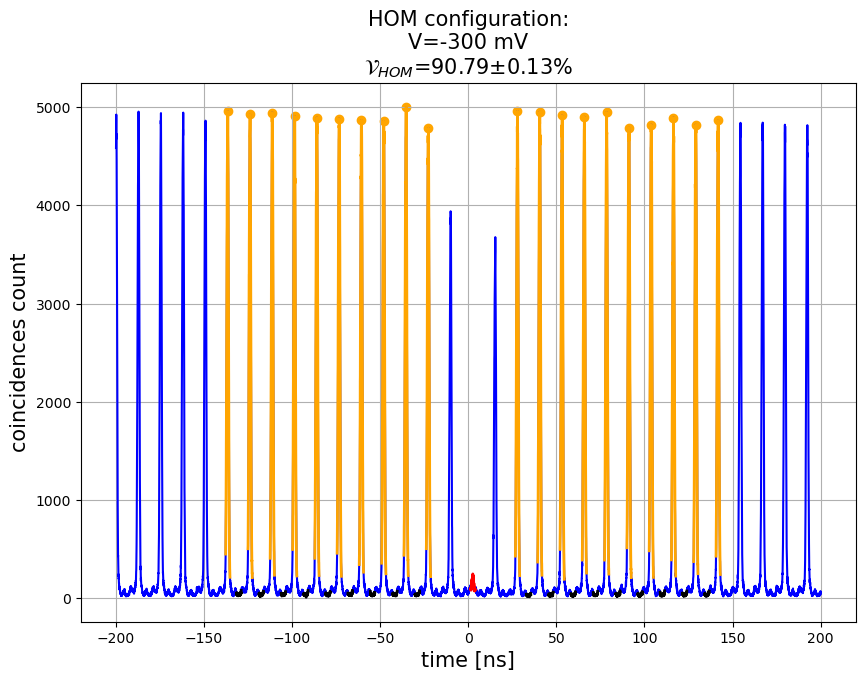

In [12]:
bars=data_read['bars']
compute_G2_HOM(bars, V=-300, HOM_choice = True, stamp_plot = True, int_peak = 10)